In [42]:
import pandas
from sklearn import datasets

In [43]:
iris_data = datasets.load_iris()
X = iris_data['data']
y = iris_data['target']

len(X)

150

# Shuffle dataset and split into train and test

In [44]:
from sklearn.model_selection import train_test_split
import numpy as np
sets = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = list(map(np.array, sets))
len(X_train)

120

In [45]:
import math
from numpy.typing import NDArray

def distance(point1: NDArray , point2: NDArray) -> int:
    squared_diff_sum = sum((x2 - x1) ** 2 for x1, x2 in zip(point1, point2))
    return math.sqrt(squared_diff_sum)

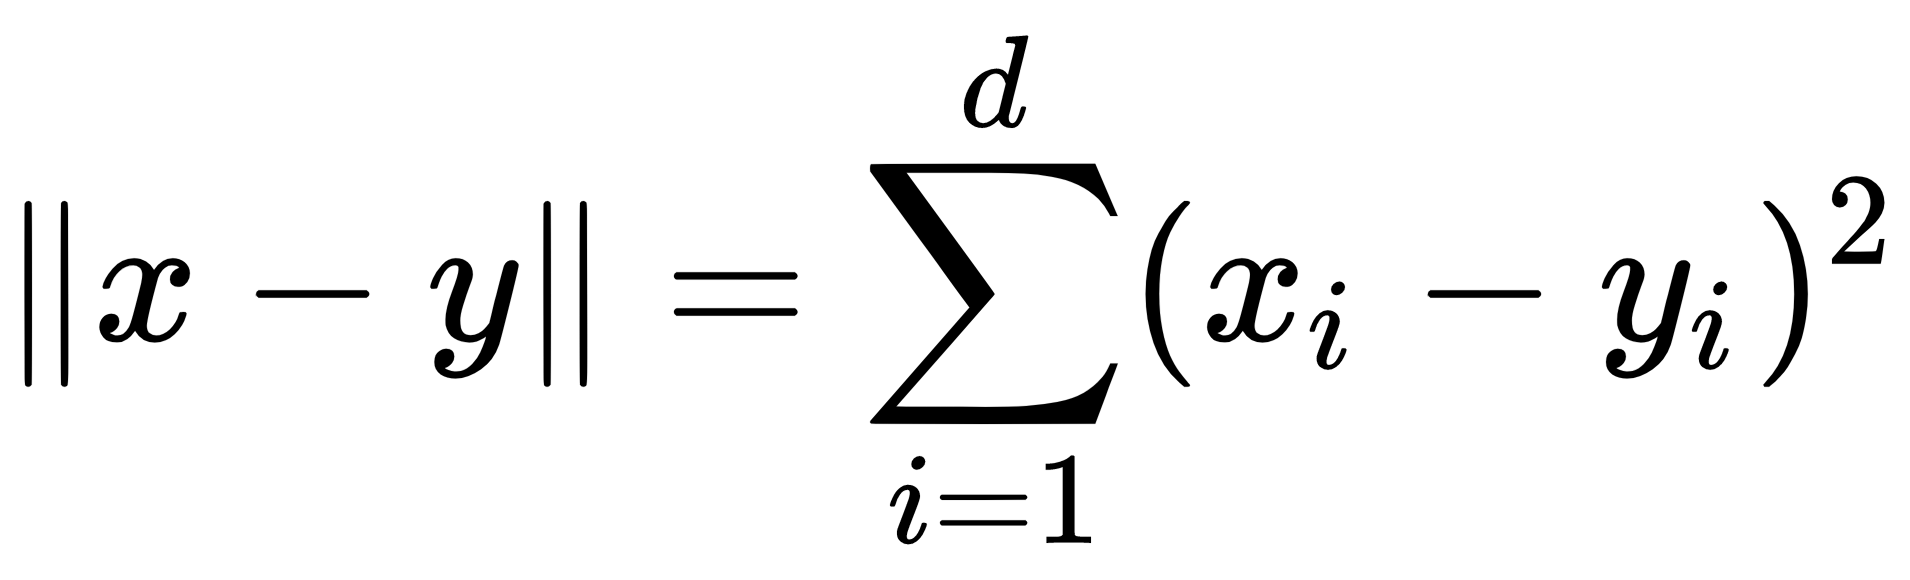

In [46]:
def add_or_decline(nearest_neighbors: list[NDArray], n: int, candidate_point: NDArray, center_point: NDArray) -> list[tuple[NDArray, float]]:
    distance_to_candidate = distance(candidate_point, center_point)
    
    is_empty = len(nearest_neighbors) == 0

    if is_empty:
        nearest_neighbors.append((candidate_point, distance_to_candidate))
        return nearest_neighbors

    _, distance_to_last = nearest_neighbors[-1]
    is_full = len(nearest_neighbors) == n
    
    if distance_to_last < distance_to_candidate and not is_full:
        nearest_neighbors.append((candidate_point, distance_to_candidate))
        return nearest_neighbors

    if distance_to_last < distance_to_candidate and is_full:
        return nearest_neighbors

    for i, data in enumerate(nearest_neighbors):
        _, distance_to_neighbor = data
        if distance_to_candidate < distance_to_neighbor:
            nearest_neighbors.insert(i, (candidate_point, distance_to_candidate))
            return nearest_neighbors[:n] if is_full else nearest_neighbors
        
    return nearest_neighbors
        
neighbors = [1, 1,1], [1, 2,-30], [100, 100, -1], [1000,1000, 0]
        
result = add_or_decline(nearest_neighbors=[(neighbor, distance([0,0,0], neighbor)) for neighbor in neighbors], n=6, candidate_point=[98,1, -20], center_point=[0,0,0])

result

[([1, 1, 1], 1.7320508075688772),
 ([1, 2, -30], 30.083217912982647),
 ([98, 1, -20], 100.024996875781),
 ([100, 100, -1], 141.42489172702236),
 ([1000, 1000, 0], 1414.213562373095)]

## Take random sample

In [47]:
import random

random_test_index = random.randint(0, len(X_test)-1)
random_X_test, random_y_test  = X_test[random_test_index], y_test[random_test_index]

In [48]:
def get_nearest_neighbors(X_train: NDArray, X_test: NDArray, n: int):
    nearest_neighbors = []

    for attributes in X_train:
        nearest_neighbors = add_or_decline(
            nearest_neighbors, n, attributes, X_test
        )
        
    return nearest_neighbors

nearest_neighbors = get_nearest_neighbors(X_train, random_X_test, 17)

distances = [distance for neighbor, distance in nearest_neighbors]
distances

[0.30000000000000027,
 0.3162277660168378,
 0.31622776601683783,
 0.33166247903553986,
 0.3741657386773941,
 0.40000000000000036,
 0.412310562561766,
 0.45825756949558405,
 0.4582575694955845,
 0.4690415759823425,
 0.4690415759823426,
 0.5196152422706634,
 0.5477225575051662,
 0.556776436283002,
 0.6164414002968976,
 0.6403124237432846,
 0.6855654600401043]

In [49]:
from attr import dataclass


@dataclass(frozen=True)
class Point:
    x: float
    y: float
    z: float
    w: float

    def __hash__(self) -> int:
        return hash((self.x, self.y, self.z, self.w))


## Determine classes of neighbors

In [50]:
train_dict = {Point(*x): y for (x,y) in zip(X_train, y_train)}

In [51]:

from collections import defaultdict


def get_max_class(nearest_neighbors: NDArray) -> tuple[int, dict[Point, int]]:
    nearest_classes = [train_dict[Point(*x)] for x, _ in nearest_neighbors]
    count = defaultdict(int)

    for near_class in nearest_classes:
        count[near_class]+=1
        
    return max(count, key=count.get), count

max_class, count = get_max_class(nearest_neighbors)

print("Class with the highest count:", max_class, "Count:", count[max_class])
print("Original class:", random_y_test)


Class with the highest count: 1 Count: 16
Original class: 1


In [52]:
def generate_random_test_pair():
    random_test_index = random.randint(0, len(X_test)-1)
    return X_test[random_test_index], y_test[random_test_index]

In [53]:
neighbors_count_options = [1, 3, 9, 13, 17 ,27, 32, 45, 49, 81, 101, 119]
random_tests = [generate_random_test_pair() for _ in range(8)]
study_results: dict[int, list[bool]] = defaultdict(list)

for count_option in neighbors_count_options:
    for X_test_case, y_test_case in random_tests:
        neighbors = get_nearest_neighbors(X_train, X_test_case, count_option)
        max_class, count = get_max_class(neighbors)
        was_correct = max_class==y_test_case
        study_results[count_option].append((y_test_case, max_class))

In [54]:
def study_results_to_test_cases(study_results: dict[int, tuple[int]]) -> list[tuple[list[int]]]:
    test_cases = []
    for _, value in study_results.items():
        true_labels = [true_label for true_label, _ in value]
        predicted_labels = [predicted for _, predicted in value]
        test_cases.append((true_labels, predicted_labels))
        
    return test_cases

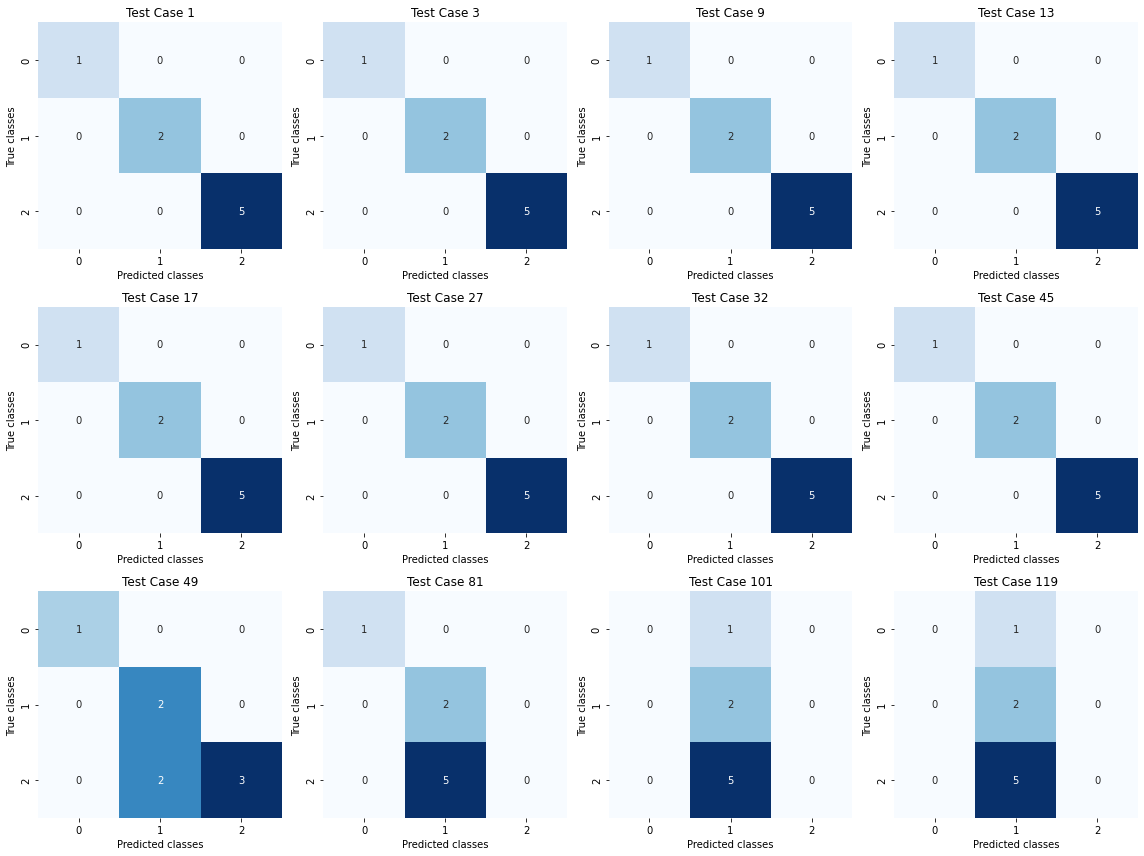

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def print_confusion_matrices(study_results: dict[int, tuple[int]]):
    test_cases = study_results_to_test_cases(study_results)

    # Create subplots for each confusion matrix
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    
    keys = list(study_results.keys())

    for i, (true_labels, predicted_labels) in enumerate(test_cases):
        row = i // 4
        col = i % 4

        # Generate confusion matrix
        cm = confusion_matrix(true_labels, predicted_labels)

        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[row, col])
        axes[row, col].set_xlabel('Predicted classes')
        axes[row, col].set_ylabel('True classes')
        axes[row, col].set_title(f'Test Case {keys[i]}')

    # Adjust layout
    plt.tight_layout()
    plt.show()
    
print_confusion_matrices(study_results)


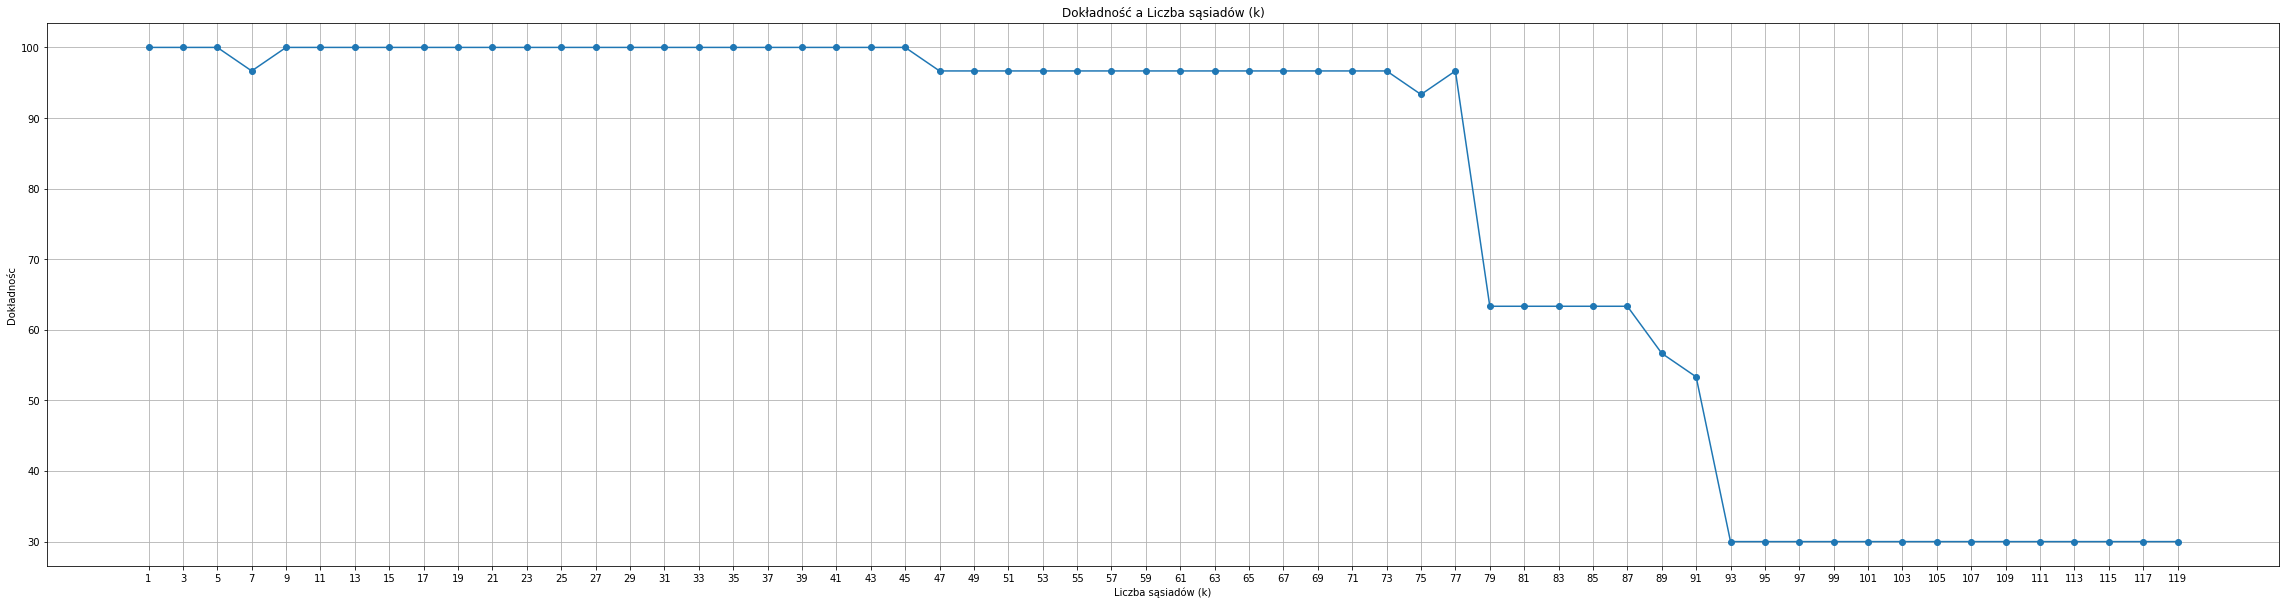

In [56]:
k_values = range(1, len(X_train), 2)

accuracies = []

for k in k_values:
    correct_count = 0
    for X_test_case, y_test_case in zip(X_test, y_test):
        neighbors = get_nearest_neighbors(X_train, X_test_case, k)
        max_class, count = get_max_class(neighbors)
        was_correct = max_class == y_test_case
        if was_correct:
            correct_count+=1

    accuracies.append((correct_count/len(X_test))*100)

plt.figure(figsize=(40, 10))

plt.plot(k_values, accuracies, marker='o')
plt.title('Dokładność a Liczba sąsiadów (k)')
plt.xlabel('Liczba sąsiadów (k)')
plt.ylabel('Dokładnośc')
plt.xticks(k_values)
plt.grid(True)
plt.show()

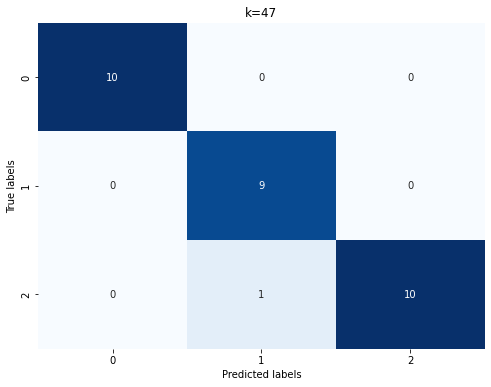

In [57]:
random_test_pairs = generate_random_test_pair()
best = 47
true_labels = []
predicted_labels = []

for X_test_case, y_test_case in zip(X_test, y_test):
        neighbors = get_nearest_neighbors(X_train, X_test_case, 47)
        max_class, _ = get_max_class(neighbors)
        true_labels.append(y_test_case)
        predicted_labels.append(max_class)
# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'k={best}')
plt.show()